<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./231_Metop-AB_IASI_NH3_L2_load_browse.ipynb"><< 231 - Metop-A/B IASI - NH3 - Level 2</a><span style="float:right;"><a href="./241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb">241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2>></a></span>

<div class="alert alert-block alert-success">
<b>20 - DATA DISCOVERY</b></div>

<div class="alert alert-block alert-success">

<b>SEE ALSO</b>

* **30 - CASE STUDIES**
  - [317 - Indonesian fires 2015](../30_case_studies/317_fire_indonesia_2015.ipynb)
  - [318 - Indonesian fires 2020](../30_case_studies/318_fire_indonesia_2020.ipynb)
  - [319 - Portugal fires 2020](../30_case_studies/319_fire_portugal_2020.ipynb)

</div>

<hr>

# 2.3.2 IASI - Level 2 - Carbon Monoxide (CO)

The [Infrared Atmospheric Sounding Interferometer (IASI)](https://www.eumetsat.int/iasi) is an instrument onboard the Metop-A/B satellites. It provides information on the vertical structure of temperature and humidity as well as main atmospheric species.

IASI data are distributed via:
- the [EUMETSAT data centre (Earth Observation Portal)](https://eoportal.eumetsat.int/userMgmt/register.faces), and
- external services, e.g. [AERIS](https://www.aeris-data.fr/).

IASI Level 2 data are disseminated in `BUFR` originally. AERIS implemented the [IASI portal](https://iasi.aeris-data.fr/), which provides the data in `txt` and `netCDF`.

#### Indonesian Fires 2015

In 2015, devastating wildfires in Indonesia broke out. According to [Reuters](https://www.reuters.com/article/us-indonesia-politics-haze-analysis-idUSKCN1UV0ZJ), "Between June and October that year, about 2.6 million hectares (6.4 million acres) of land burned in Indonesia, mainly on Sumatra and Borneo islands, said a 2016 World Bank report. A Harvard University study linked the 2015 haze to more than 100,000 premature deaths in Indonesia, Malaysia and Singapore."

#### This module has the following outline:
* [1 - Load and browse Metop-A/B IASI Level 2 data](#load)
* [2 - Mask Metop-A/B IASI Level 2 data](#masking)
* [3 - Combine Metop-A/B IASI Level 2 data](#combine)
* [4 - Bin Metop-A/B IASI Level 2 data](#binning)
* [5 - Visualize Metop-A/B IASI Level 2 data](#visualize)

#### Load required libraries

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import ipynb

from netCDF4 import Dataset
import pandas as pd


from matplotlib import animation

from IPython.display import HTML
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

#### Load helper functions

In [4]:
%run ../functions.ipynb

<hr>

## <a id="load"></a>Load and browse Metop-A/B IASI Level 2 products

IASI Level 2 CO data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `txt` format in 2015. You can use the Python library [pandas](https://pandas.pydata.org) to access and manipulate datasets in `txt` format.

The following examples shows an example of `Carbon monoxide (CO)`.

### <a id='step1'></a>Load the Metop-A IASI Level 2 data with `pandas`

IASI Total Column Carbon Monoxide data are disseminated in `.txt` format. You can easily load the .txt file with the pandas function `pd.read_csv()`, using an empty string as seperator.

The pandas function `.head()` shows you the first entries of the loaded file.

In [7]:
iasi_file = '../eodata/iasi/txt/co/2a/2015/09/09/iasi_CO_LATMOS_ULB_20150909_v20140922.txt'


In [8]:
iasi_co = pd.read_csv(iasi_file, sep=" ", header = None)
iasi_co.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,56.66836,-69.74904,20150909,259,96.95,1,0,0,0,0,...,2.365902,2.251876,2.008893,1.770233,1.599311,1.454534,1.330921,1.202729,1.080917,-0.330595
1,56.40126,-70.50591,20150909,259,96.66,2,0,0,0,0,...,2.374669,2.320618,2.088976,1.803872,1.609957,1.452753,1.323877,1.195579,1.081573,-0.339866
2,56.17440,-70.23203,20150909,259,96.88,3,0,0,0,0,...,2.360759,2.327788,2.126293,1.846213,1.642612,1.472643,1.335170,1.195982,1.065666,-0.340553
3,57.08389,-67.72364,20150909,259,97.82,0,0,0,0,0,...,2.274544,2.147204,1.867447,1.584539,1.403302,1.252968,1.125439,1.011367,0.918079,-0.237075
4,57.28990,-67.95295,20150909,259,97.63,1,0,0,0,0,...,2.352564,2.218646,1.932256,1.626201,1.451941,1.326538,1.213669,1.082594,0.969588,-0.247227


#### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) to load the `Total Column Carbon Monoxide` information into a `xarray.DataArray`.

The data holds a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information into a `xarray.DataArray` as well.

In [9]:
iasi_co_da = generate_xr_from_1D_vec(file=iasi_co,
                                     lat_path=0, 
                                     lon_path=1, 
                                     variable=iasi_co[20], 
                                     parameter_name='co', 
                                     longname='IASI Carbon Monoxide Total Column', 
                                     no_of_dims=1, 
                                     unit='molec./cm-2')

iasi_co_da

<xarray.DataArray 'co' (ground_pixel: 468375)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 1.720793e+18,
       2.011679e+18, 1.710957e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 44.62 40.76 43.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 151.8 161.2 151.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

In [10]:
iasi_co_qf_da = generate_xr_from_1D_vec(file=iasi_co,
                                        lat_path=0, 
                                        lon_path=1,
                                        variable=iasi_co[15], 
                                        parameter_name='qf', 
                                        longname='Super Quality Flag', 
                                        no_of_dims=1, 
                                        unit='-')

iasi_co_qf_da

<xarray.DataArray 'qf' (ground_pixel: 468375)>
array([0, 0, 0, ..., 1, 1, 1])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 44.62 40.76 43.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 151.8 161.2 151.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Super Quality Flag
    units:      -

#### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function [generate_masked_array](../functions.ipynb#generate_masked_array) allows you to flag out the quality flags. You want to flag all pixels with a quality flag equals 0.

In [11]:
iasi_co_masked = generate_masked_array(xarray=iasi_co_da,
                                       mask=iasi_co_qf_da,
                                       threshold=0,
                                       operator='=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 363488)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 2.566273e+18,
       1.775954e+18, 2.427362e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... 45.43 46.77 44.23
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... 158.2 151.8 160.0
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

#### Load the Metop-B IASI Level 2 data with `pandas`

Let us now use `pandas` to load the data from Metop-B. We will repeat the same steps as we did for Metop-A.

In [12]:
iasi_file_b = '../eodata/iasi/txt/co/2b/2015/09/09/iasi_CO_LATMOS_ULB_metopb_20150909_v20140922.txt'


In [13]:
iasi_co_b = pd.read_csv(iasi_file_b, sep=" ", header = None)
iasi_co_b.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-45.95519,143.20297,20150909,253,60.37,1,1,0,0,0,...,1.679389,1.540492,1.349874,1.148153,0.968703,0.823212,0.699236,0.593768,0.498157,0.006721
1,-45.64839,140.32381,20150909,254,61.52,2,1,0,0,1,...,2.013606,1.871402,1.652351,1.406361,1.189546,1.016303,0.867966,0.741711,0.622416,-0.041041
2,-45.09610,136.20546,20150909,255,63.24,1,0,0,0,0,...,1.787922,1.686547,1.515197,1.303339,1.102482,0.934500,0.792027,0.669474,0.561571,-0.011777
3,-45.13663,136.44952,20150909,255,63.14,2,1,0,0,0,...,2.030403,1.924646,1.730961,1.488511,1.263497,1.075897,0.914956,0.775222,0.646970,-0.034783
4,-44.83897,135.61980,20150909,255,63.39,0,1,0,0,0,...,1.921038,1.827848,1.649180,1.417723,1.196915,1.012524,0.856973,0.723208,0.603006,-0.033066


#### Load data into a xarray with the function `generate_xr_from_1D_vec`

The IASI Carbon Monoxide data are stored in column 20 of the data file. You can use the function [generate_xr_from_1D_vec](../functions.ipynb#generate_xr_from_1D_vec) to load the `Total Column Carbon Monoxide` information into a `xarray.DataArray`.

The data holds a `Super Quality Flag`, which should be masked out. The quality flag is stored in column 15. You can load the flag information into a `xarray.DataArray` as well.

In [14]:
iasi_co_b_da = generate_xr_from_1D_vec(file=iasi_co_b,
                                     lat_path=0, 
                                     lon_path=1, 
                                     variable=iasi_co_b[20], 
                                     parameter_name='co', 
                                     longname='IASI Carbon Monoxide Total Column', 
                                     no_of_dims=1, 
                                     unit='molec./cm-2')

iasi_co_b_da

<xarray.DataArray 'co' (ground_pixel: 483390)>
array([1.281433e+18, 1.314173e+18, 1.308412e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.65 -45.1 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 140.3 136.2 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

In [15]:
iasi_co_b_qf_da = generate_xr_from_1D_vec(file=iasi_co_b,
                                        lat_path=0, 
                                        lon_path=1,
                                        variable=iasi_co_b[15], 
                                        parameter_name='qf', 
                                        longname='Super Quality Flag', 
                                        no_of_dims=1, 
                                        unit='-')

iasi_co_b_qf_da

<xarray.DataArray 'qf' (ground_pixel: 483390)>
array([0, 1, 0, ..., 0, 0, 0])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.65 -45.1 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 140.3 136.2 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Super Quality Flag
    units:      -

#### Mask the Total Column Carbon Monoxide data with the `Super Quality Flag`

The function [generate_masked_array](../functions.ipynb#generate_masked_array) allows you to flag out the quality flags. You want to flag all pixels with a quality flag equals 0.

In [16]:
iasi_co_b_masked = generate_masked_array(xarray=iasi_co_b_da,
                                       mask=iasi_co_b_qf_da,
                                       threshold=0,
                                       operator='=')
iasi_co_b_masked

<xarray.DataArray (ground_pixel: 378069)>
array([1.281433e+18, 1.308412e+18, 1.386403e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 -45.96 -45.1 -45.14 ... -60.07 -60.22
    longitude  (ground_pixel) float64 143.2 136.2 136.4 ... -22.76 -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

## <a id="combine"></a>Combine Metop A/B IASI Level 2 products

Now, you concatenate the `xarray.DataArrays` from Metop-A and Metop-B into one single `DataArray`. You can use the function `xarray.concat` for it and use the dimension `ground_pixel` as concatenation dimension.

#### Combine the two Carbon monoxide data arrays from Metop-A and Metop-B `xarray.concat`

In [17]:
co_2ab_da = xr.concat([iasi_co_masked,iasi_co_b_masked],dim='ground_pixel')
co_2ab_da

<xarray.DataArray (ground_pixel: 741557)>
array([1.941420e+18, 1.974603e+18, 1.896928e+18, ..., 1.286893e+18,
       1.329418e+18, 1.263436e+18])
Coordinates:
    latitude   (ground_pixel) float64 56.67 56.4 56.17 ... -60.02 -60.07 -60.22
    longitude  (ground_pixel) float64 -69.75 -70.51 -70.23 ... -23.07 -22.96
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

## <a id="binning"></a>Bin the Metop-A/B IASI data

### Binning of Metop-A/B IASI Level-2 data onto a regular two-dimensional grid

The next step is to bring the ground pixel information of the `co_2ab_da` array onto a regular two-dimensional grid. This process is called *binning*. In preparation, you store the data values of `latitude`, `longitude` and `CO_total_column` as variables x, y, z.

In [18]:
y = co_2ab_da.latitude.data
x = co_2ab_da.longitude.data
z = co_2ab_da.data

<br>

#### Bin the data onto a 2D-grid with `np.histogram2d`

With `np.histogram2d`, you can bin the data onto a pre-defined two-dimensional grid (called bins). By assigning the data value object `z` to the keyword argument `weights`, the bin gets assigned the data value of the point that falls into the cell.

Since there will be more data points assigned to one cell (bin), you also have to create a `counts` array, which sums up the number of data points fallen into a bin. With this `counts` array, you can build the arithmetic mean of all the data points fallen into a bin.

The example below builds a regular grid of 1 deg x 1 deg.

In [19]:
zi, yi, xi = np.histogram2d(y, x, bins=(180,360), weights=z, normed=False)
counts, _, _ = np.histogram2d(y, x, bins=(180,360))
    
zi = zi / counts
zi

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan, 9.16743000e+17, 9.12972525e+17, ...,
                   nan,            nan,            nan],
       ...,
       [1.97650900e+18, 2.13348800e+18,            nan, ...,
        2.03848750e+18,            nan, 2.29839800e+18],
       [1.94472700e+18,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

You can create a `xarray.DataArray` from the binned information, which gives you flexibility in further handling the regularly gridded ozone values.

<br>

#### Create a `xarray.DataArray` of the regular gridded Carbon monoxide information

You can create a `xarray.DataArray` with the constructor `DataArray()`. Define the array with two dimensions, `latitude` and `longitude`, but add `time` as an additional coordinate information.

In [20]:
xarray_ab = xr.DataArray(
                zi,
                dims=['latitude','longitude'],
                coords={
                    'time': pd.to_datetime('2015-09-09'),
                    'latitude':(['latitude'], yi[:-1]),
                    'longitude':(['longitude'],xi[:-1])
                },
                attrs={'long_name': co_2ab_da.long_name, 'units': co_2ab_da.units},
                name='CO'
            )

xarray_ab

<xarray.DataArray 'CO' (latitude: 180, longitude: 360)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan, 9.16743000e+17, 9.12972525e+17, ...,
                   nan,            nan,            nan],
       ...,
       [1.97650900e+18, 2.13348800e+18,            nan, ...,
        2.03848750e+18,            nan, 2.29839800e+18],
       [1.94472700e+18,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
    time       datetime64[ns] 2015-09-09
  * latitude   (latitude) float64 -87.88 -86.9 -85.91 ... 86.27 87.26 88.24
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
Attributes:
    long_name:  IASI Carbon Monoxide Total Column
    units:      molec./cm-2

<br>

##  <a id="visualize"></a>Visualize the Metop-A/B IASI data

#### Visualize the data array in an `Orthographic()` projection with the function `visualize_pcolormesh`

The final step is to visualize the gridded data with the function [visualize_pcolormesh](./functions.ipynb#visualize_pcolormesh).

The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

(<Figure size 1440x720 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'IASI L2 METOP-A/B IASI Carbon Monoxide Total Column from 2015-09-09'}>)

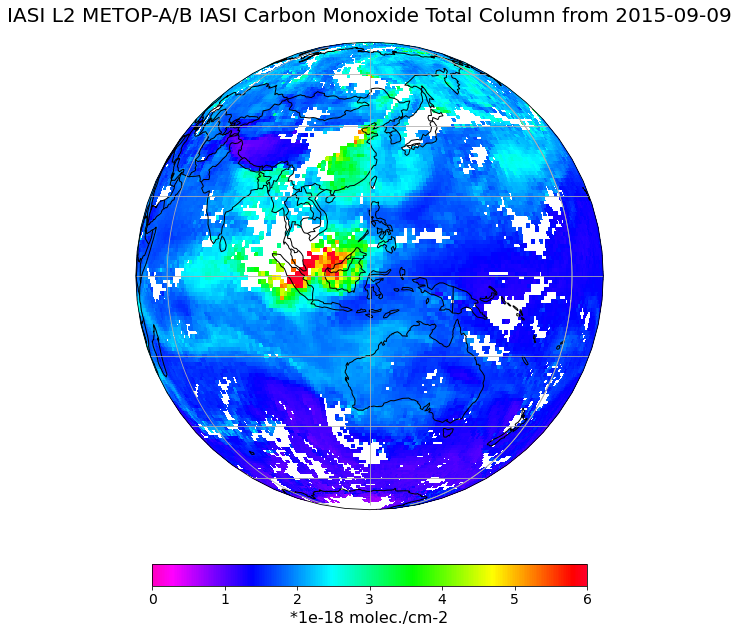

In [21]:
visualize_pcolormesh(data_array=xarray_ab*1e-18, 
                     longitude=xarray_ab.longitude, 
                     latitude=xarray_ab.latitude, 
                     projection=ccrs.Orthographic(120), 
                     color_scale='gist_rainbow_r', 
                     unit='*1e-18 ' + xarray_ab.units, 
                     long_name= "IASI L2 METOP-A/B " + xarray_ab.long_name + " from " + str(xarray_ab.time.data)[0:10], 
                     vmin=0, 
                     vmax=6,
                     set_global=True
                    )

<br>

<a href="../00_index.ipynb"><< Index</a><br>
<a href="./231_Metop-AB_IASI_NH3_L2_load_browse.ipynb"><< 231 - Metop-A/B IASI - NH3 - Level 2</a><span style="float:right;"><a href="./241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb">241 - Sentinel-5P TROPOMI - Carbon Monoxide - Level 2>></a></span>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>